# Microbial Growth Rates in R

*Tom Smith, Jan 2020*

There are various ways to estimate microbial population growth rates from different types of abundance data. Here we will take a look at some different approaches, from applying linear models to the exponential phase, through to fitting non-linear models to the full growth curve.

We're going to use various R packages: ggplot for nice figures, minpack.lm for levenberg marquardt nls fitting, zoo and dplyr for useful functions to perform a rolling regression (you'll see later), and finally [nls.multstart](https://github.com/padpadpadpad/nls.multstart) for an alternative to estimating nls starting parameters.

In [19]:
library("ggplot2")
library("minpack.lm")
library("zoo")
library("dplyr")
library("nls.multstart")

First off, lets make an example dataset of microbial popultion growth by cell counts which produces a plausible looking sigmoidal growth curve

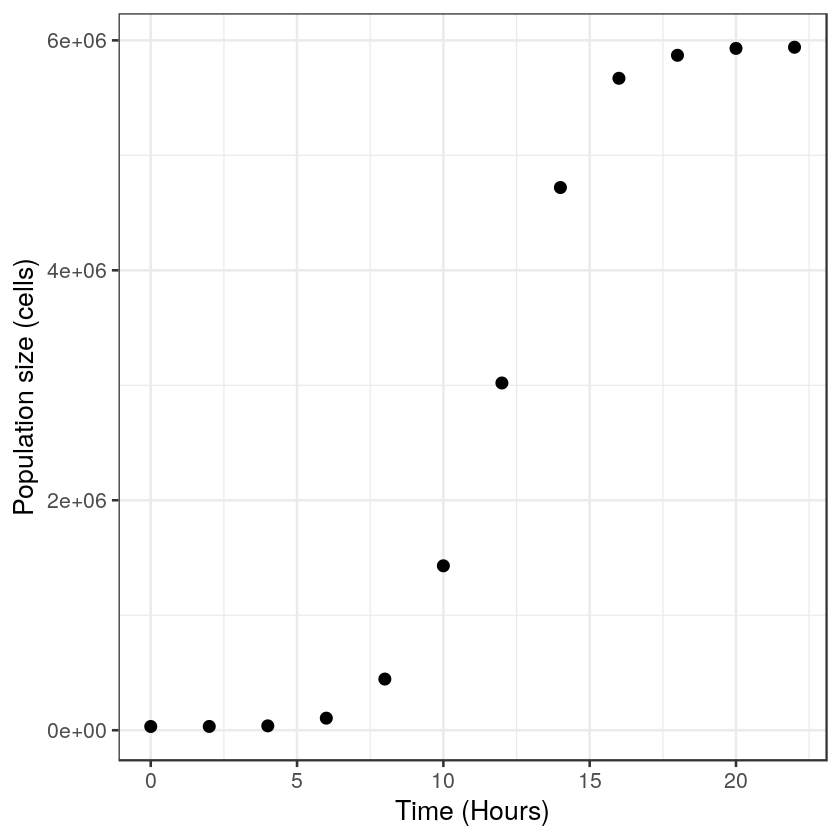

In [20]:
t <- seq(0, 22, 2)
N <- c(32500, 33000, 38000, 105000, 445000, 1430000, 3020000, 4720000, 5670000, 5870000, 5930000, 5940000)

data <- data.frame(t, N)


ggplot(data, aes(x = t, y = N)) + 
    geom_point(size = 3) +
    labs(x = "Time (Hours)", y = "Population size (cells)") +
    theme_bw(base_size = 16)

## Basic linear approaches

OK, so how do we calculate the growth rate from these data?

The size of an exponentially growing population ($N$) at any given time ($t$) is given by:

$
\begin{align}
N(t) = N_0 \cdot e^{rt} ,
\end{align}
$

where $N_0$ is the initial population size and $r$ is the growth rate. We can re-arrange this to give:

$
\begin{align}
r = \frac{log(N(t)) - log(N_0)}{t} ,
\end{align}
$

i.e. in exponential growth at a constant rate, the growth rate can be simply calculated as the difference in the log of two population sizes, over time. We will log-transform the data and estimate by eye where growth looks to be exponential.

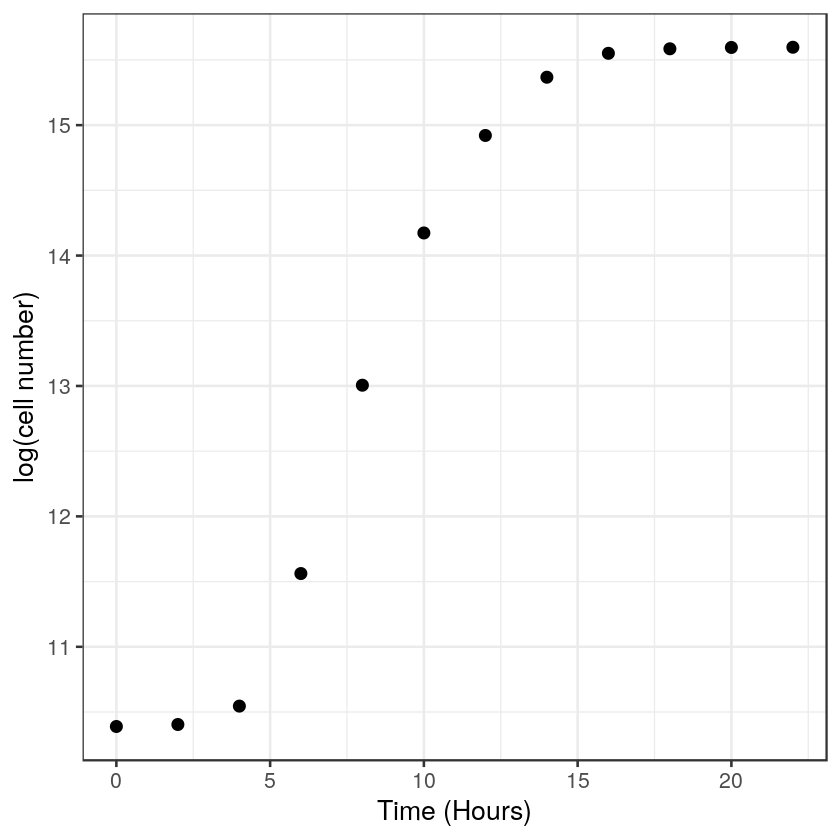

In [21]:
data$LogN <- log(data$N)
data$Log10N <- log10(data$N) # for later

# visualise
ggplot(data, aes(x = t, y = LogN)) + 
    geom_point(size = 3) +
    labs(x = "Time (Hours)", y = "log(cell number)") +
    theme_bw(base_size = 16)

By eye the logged data looks fairly linear between hours 4 and 10, so we'll use that time-period to calculate the growth rate. 

In [22]:
(data[data$t == 10,]$LogN - data[data$t == 4,]$LogN)/(10-4)

[1] 0.6046406

So our first, most basic estimate of $r$ is around 0.6.

But we can do better than this. To account for some error in measurement, we shouldn't really take the data points directly, but fit a linear model through them instead, where the slope gives our growth rate. This is pretty much the "traditional" way to calculate microbial growth rates - draw a straight line through the linear part on log-transformed data.

In [23]:
lm_growth <- lm(LogN ~ t, data = data[data$t > 2 & data$t < 12,])
summary(lm_growth)


Call:
lm(formula = LogN ~ t, data = data[data$t > 2 & data$t < 12, 
    ])

Residuals:
       3        4        5        6 
 0.07297 -0.14342  0.06793  0.00252 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  8.00684    0.20297   39.45 0.000642 ***
t            0.61638    0.02762   22.32 0.002002 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1235 on 2 degrees of freedom
Multiple R-squared:  0.996,	Adjusted R-squared:  0.994 
F-statistic:   498 on 1 and 2 DF,  p-value: 0.002002


About the same $r \approx 0.62$. 

But this is still not great, we only estimated the exponential phase by eye, we could do it better by iterating through different windows of points, comparing the slopes and finding which the highest is to give the maximum growth rate, $r_{max}$. This is called a rolling regression.

## Rolling regression

I'm going to borrow the code from one of Dan Padfield's github posts to do it: https://padpadpadpad.github.io/post/calculating-microbial-growth-rates-from-od-using-rolling-regression/
This requires zoo::rollapplyr() and dplyr::do()

Joining, by = "t"


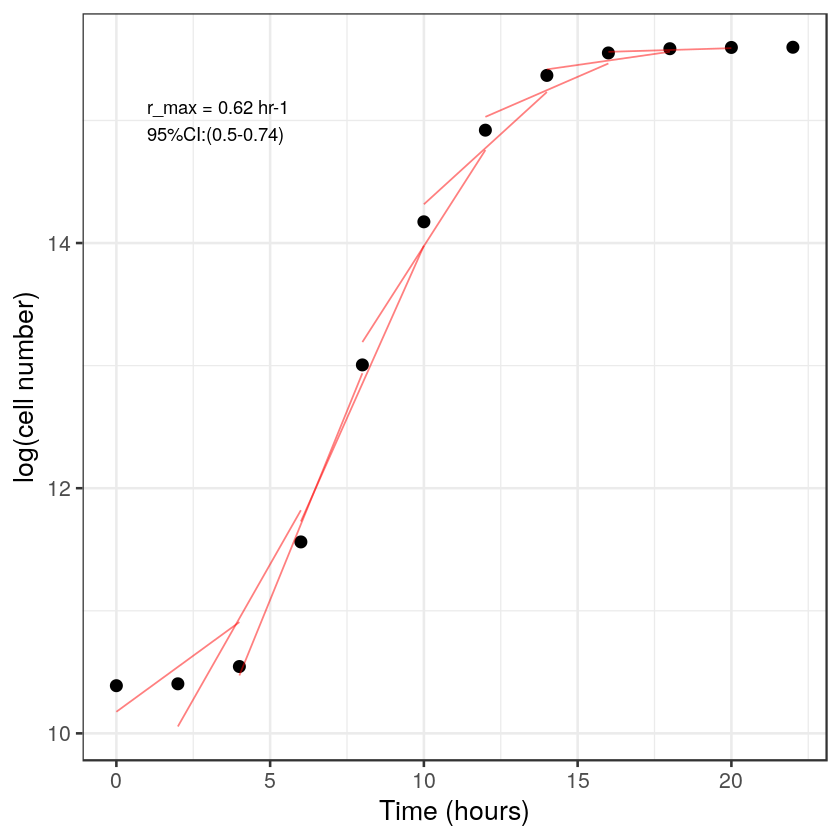

In [24]:
# create the rolling regression function
roll_regress <- function(x){
  temp <- data.frame(x)
  mod <- lm(temp)
  temp <- data.frame(slope = coef(mod)[[2]],
                     slope_lwr = confint(mod)[2, ][[1]],
                     slope_upr = confint(mod)[2, ][[2]],
                     intercept = coef(mod)[[1]],
                     rsq = summary(mod)$r.squared, stringsAsFactors = FALSE)
  return(temp)
}

# define window - here every ~8 hours (window of 4 points)
num_points <- 4

# run rolling regression on logN ~ t
models <- data %>%
  do(cbind(model = select(., LogN, t) %>% 
             zoo::rollapplyr(width = num_points, roll_regress, by.column = FALSE, fill = NA, align = 'center'),
           time = select(., t),
           ln_od = select(., LogN))) %>%
  rename_all(., gsub, pattern = 'model.', replacement = '')

# create predictions
preds <- models %>%
  filter(., !is.na(slope)) %>%
  group_by(t) %>%
  do(data.frame(time2 = c(.$t - 2, .$t + 2))) %>%
  left_join(., models) %>%
  mutate(pred = (slope*time2) + intercept)

growth_rate <- filter(models, slope == max(slope, na.rm = TRUE))

# plot rolling regression
ggplot(data, aes(t, LogN)) +
  geom_point(size = 3) +
  geom_line(aes(time2, pred, group = t), col = 'red', preds, alpha = 0.5) +
  theme_bw(base_size = 16) +
  annotate(geom = 'text', x = 1, y = 15, label = paste('r_max = ', round(growth_rate$slope, 2), ' hr-1\n95%CI:(',round(growth_rate$slope_lwr, 2), '-', round(growth_rate$slope_upr, 2), ')', sep = ''), hjust = 0) +
  labs(x = "Time (hours)",
       y = "log(cell number)")

There we go, same answer as before, but we've done it iteratively to find the highest slope rather than estimate it by eye.

This is fine, but probably quite computationally intensive were we trying to do this for a large dataset of different growth curves. It would be better to just fit a single model to the full curve and pull out the growth rate that way. 

## nls model fitting

One seemingly useful model would be the logistic growth equation where the growth rate slows as the population size nears carrying capacity (usually given as $K$ in the ecological literature, but here we'll use $N_{max}$).

In [25]:
logistic_model <- function(t, r_max, N_max, N_0){ # The classic logistic equation
  return(N_0 * N_max * exp(r_max * t)/(N_max + N_0 * (exp(r_max * t) - 1)))
}

# first we need some starting parameters for the model
N_0_start <- min(data$N) # lowest population size
N_max_start <- max(data$N) # highest population size
r_max_start <- 0.62 # use our linear estimate from before

fit_logistic <- nlsLM(N ~ logistic_model(t = t, r_max, N_max, N_0), data,
                      list(r_max=r_max_start, N_0 = N_0_start, N_max = N_max_start))

summary(fit_logistic)


Formula: N ~ logistic_model(t = t, r_max, N_max, N_0)

Parameters:
       Estimate Std. Error t value Pr(>|t|)    
r_max 6.379e-01  1.444e-02  44.186 7.78e-12 ***
N_0   2.993e+03  5.051e+02   5.925 0.000222 ***
N_max 5.988e+06  2.935e+04 204.044  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 48220 on 9 degrees of freedom

Number of iterations to convergence: 11 
Achieved convergence tolerance: 1.49e-08


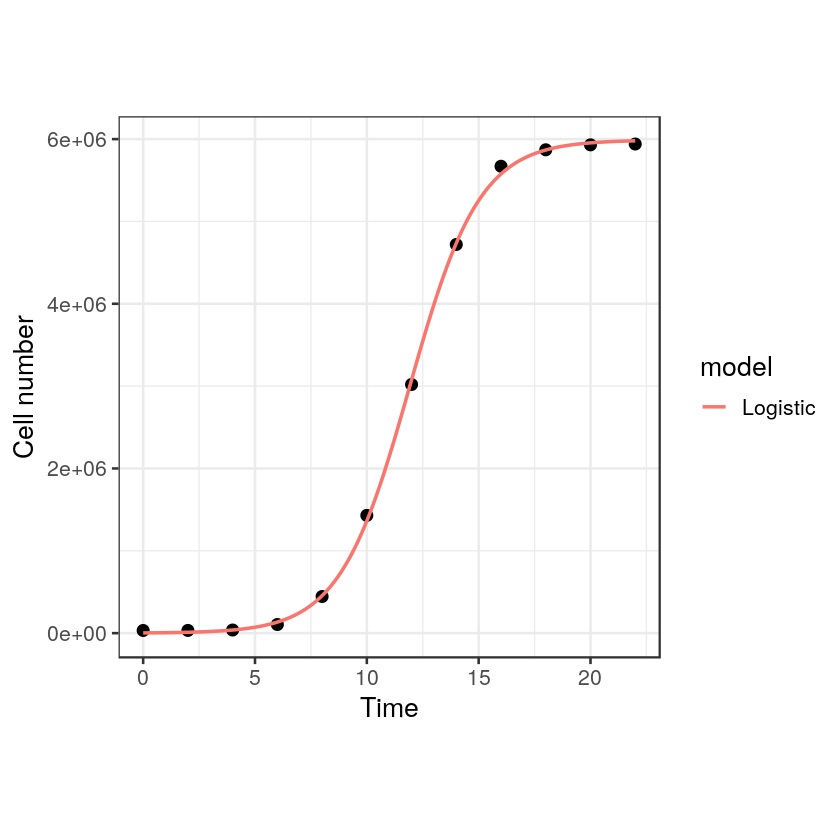

In [34]:
# plot it:
timepoints <- seq(0, 22, 0.1)

logistic_points <- logistic_model(t = timepoints, r_max = coef(fit_logistic)["r_max"], N_max = coef(fit_logistic)["N_max"], N_0 = coef(fit_logistic)["N_0"])
df1 <- data.frame(timepoints, logistic_points)
df1$model <- "Logistic"
names(df1) <- c("t", "N", "model")

ggplot(data, aes(x = t, y = N)) +
  geom_point(size = 3) +
  geom_line(data = df1, aes(x = t, y = N, col = model), size = 1) +
  theme_bw(base_size = 16) + # make the background white
  theme(aspect.ratio=1)+ # make the plot square 
  labs(x = "Time", y = "Cell number")

That looks nice, and it gives us an $r_{max}$ estimate fairly close to what we had before: 0.64. Note that we've done this fitting to the original non transformed data, whilst the linear regressions earlier were on log transformed data. What would this function look like on a log-transformed axis?

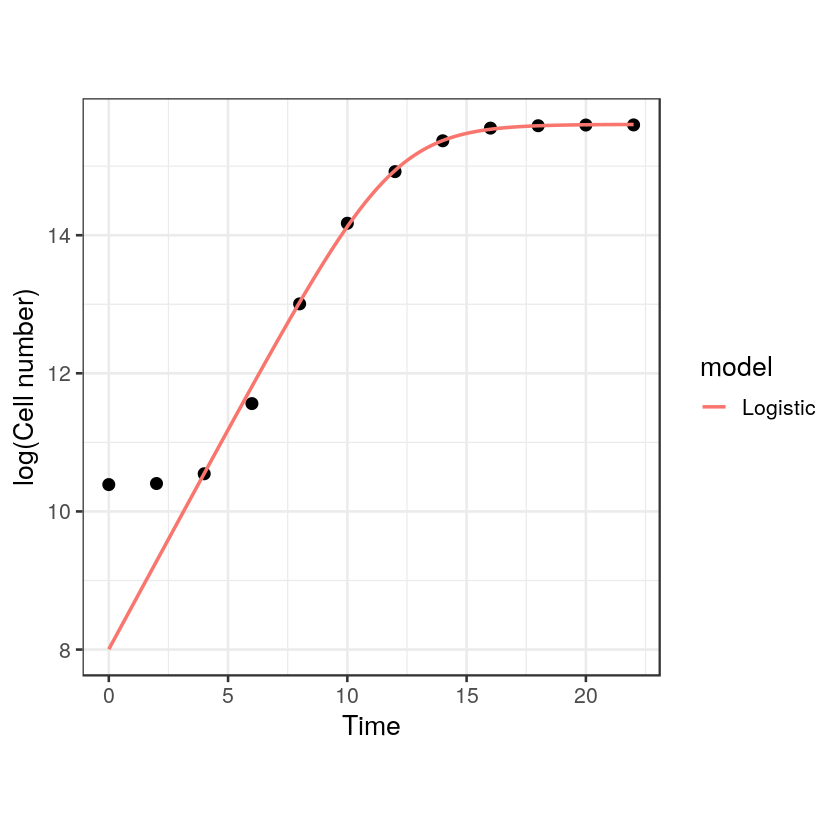

In [35]:
ggplot(data, aes(x = t, y = LogN)) +
  geom_point(size = 3) +
  geom_line(data = df1, aes(x = t, y = log(N), col = model), size = 1) +
  theme_bw(base_size = 16) + 
  theme(aspect.ratio=1)+ 
  labs(x = "Time", y = "log(Cell number)")


Aha, something weird happens at the lower end where our model diverges from the data. This is because the logistic model assumes that the population is growing from the start, however this is not true to reality for batch cultures of bacteria. 

When bacteria are sub-cultured into fresh media, they take some time to acclimate to their new surroundings, activating genes involved in nutrient uptake and metabolic processes before beginning exponential growth. This is called the lag phase and can be seen in our example data where exponential growth doesn't properly begin until around the 4th hour.

Various models have been devised to describe bacterial growth curves which include a lag phase before exponential growth begins. Here we will look at 3 - Gomertz, Baranyi and Buchanan. These all contain our three parameters from before ($N_0$, $N_{max}$ and $r_{max}$) and introduce a new one which describes the length of the lag period - ($t_{lag}$).

The Buchanan model (or "three-phase logistic"; Buchanan, 1997) is very simplistic, based on the idea that you can get a decent estimate of bacterial growth from a simple straight line through the exponential phase on the logged data (similar to what we did earlier). It says that at $N_0$ and $N_{max}$, growth rate is zero, and between those points, growth rate is constant and $r_{max}$ is simply the slope of the line.

The Gompertz (using the log-transformed formulation of Zwietering, 1990) and Baranyi (Baranyi, 1993) models are mathematical functions describing the shape of the curve, where the maximum growth rate is estimated as the slope of the tangent to the inflection point of the curve.

First, specify the model functions.

In [30]:
gompertz_model <- function(t, r_max, N_max, N_0, t_lag){ # Modified gompertz growth model (Zwietering 1990)
  return(N_0 + (N_max - N_0) * exp(-exp(r_max * exp(1) * (t_lag - t)/((N_max - N_0) * log(10)) + 1)))
}

baranyi_model <- function(t, r_max, N_max, N_0, t_lag){  # Baranyi model (Baranyi 1993)
  return(N_max + log10((-1+exp(r_max*t_lag) + exp(r_max*t))/(exp(r_max*t) - 1 + exp(r_max*t_lag) * 10^(N_max-N_0))))
}

buchanan_model <- function(t, r_max, N_max, N_0, t_lag){ # Buchanan model - three phase logistic (Buchanan 1997)
  return(N_0 + (t >= t_lag) * (t <= (t_lag + (N_max - N_0) * log(10)/r_max)) * r_max * (t - t_lag)/log(10) + (t >= t_lag) * (t > (t_lag + (N_max - N_0) * log(10)/r_max)) * (N_max - N_0))
}

For added complication, note that these are written in log to the base 10, which means that we must use data transformed to log base 10, not the natural log as we did earlier. These could also be written in the natural log too, in which case you would natural log transform the data to fit them.

Now let's generate some starting values for the NLLS fitting, using some functions to derive these values from the  actual data:

In [31]:
# Note that we're using Log10N now
N_0_start <- min(data$Log10N)
N_max_start <- max(data$Log10N)
t_lag_start <- data$t[which.max(diff(diff(data$Log10N)))]
r_max_start <- max(diff(data$Log10N))/mean(diff(data$t))

Now fit the models:

In [32]:
fit_baranyi <- nlsLM(Log10N ~ baranyi_model(t = t, r_max, N_max, N_0, t_lag), data,
                     list(t_lag=t_lag_start, r_max=r_max_start, N_0 = N_0_start, N_max = N_max_start))

fit_buchanan <- nlsLM(Log10N ~ buchanan_model(t = t, r_max, N_max, N_0, t_lag), data,
                      list(t_lag=t_lag_start, r_max=r_max_start, N_0 = N_0_start, N_max = N_max_start))

fit_gompertz <- nlsLM(Log10N ~ gompertz_model(t = t, r_max, N_max, N_0, t_lag), data,
                      list(t_lag=t_lag_start, r_max=r_max_start, N_0 = N_0_start, N_max = N_max_start))

summary(fit_baranyi)
summary(fit_buchanan)
summary(fit_gompertz)


Formula: Log10N ~ baranyi_model(t = t, r_max, N_max, N_0, t_lag)

Parameters:
      Estimate Std. Error t value Pr(>|t|)    
t_lag  4.75158    0.26603   17.86 9.89e-08 ***
r_max  0.78662    0.04063   19.36 5.26e-08 ***
N_0    4.47239    0.03389  131.97 1.21e-14 ***
N_max  6.75633    0.02187  308.90  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0461 on 8 degrees of freedom

Number of iterations to convergence: 9 
Achieved convergence tolerance: 1.49e-08



Formula: Log10N ~ buchanan_model(t = t, r_max, N_max, N_0, t_lag)

Parameters:
      Estimate Std. Error t value Pr(>|t|)    
t_lag  3.69676    0.27025   13.68 7.86e-07 ***
r_max  0.56812    0.02251   25.24 6.51e-09 ***
N_0    4.51520    0.04372  103.27 8.63e-14 ***
N_max  6.74860    0.02765  244.05  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.06183 on 8 degrees of freedom

Number of iterations to convergence: 6 
Achieved convergence tolerance: 1.49e-08



Formula: Log10N ~ gompertz_model(t = t, r_max, N_max, N_0, t_lag)

Parameters:
      Estimate Std. Error t value Pr(>|t|)    
t_lag 4.518857   0.080944   55.83 1.18e-11 ***
r_max 0.755878   0.013951   54.18 1.49e-11 ***
N_0   4.511152   0.011237  401.47  < 2e-16 ***
N_max 6.799625   0.009583  709.56  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01693 on 8 degrees of freedom

Number of iterations to convergence: 8 
Achieved convergence tolerance: 1.49e-08


We're in and around the same ballpark figure for r_max again, though Baranyi and Gompertz estimate higher than Buchanan. Note that $N_0$ and $N_{max}$ are estimated based on our log transformation, so the true carrying capacity in terms of cell number would be $10^{N_{max}}$ for instance. 

Plot them all together to see how the fits look.

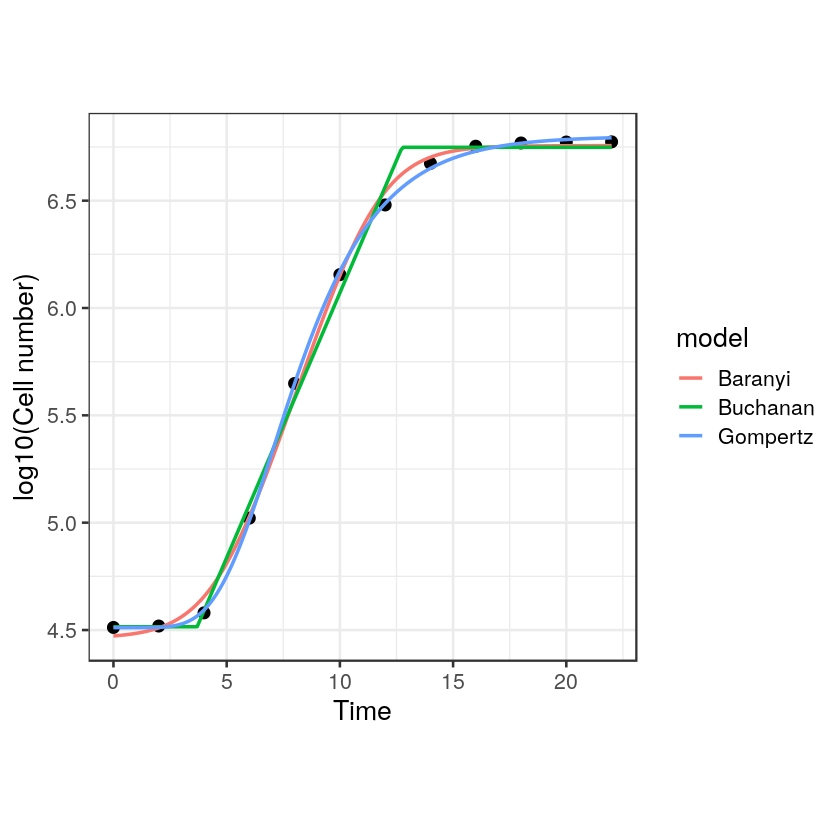

In [36]:
timepoints <- seq(0, 22, 0.1)

baranyi_points <- baranyi_model(t = timepoints, r_max = coef(fit_baranyi)["r_max"], N_max = coef(fit_baranyi)["N_max"], N_0 = coef(fit_baranyi)["N_0"], t_lag = coef(fit_baranyi)["t_lag"])

buchanan_points <- buchanan_model(t = timepoints, r_max = coef(fit_buchanan)["r_max"], N_max = coef(fit_buchanan)["N_max"], N_0 = coef(fit_buchanan)["N_0"], t_lag = coef(fit_buchanan)["t_lag"])

gompertz_points <- gompertz_model(t = timepoints, r_max = coef(fit_gompertz)["r_max"], N_max = coef(fit_gompertz)["N_max"], N_0 = coef(fit_gompertz)["N_0"], t_lag = coef(fit_gompertz)["t_lag"])

df2 <- data.frame(timepoints, baranyi_points)
df2$model <- "Baranyi"
names(df2) <- c("t", "Log10N", "model")

df3 <- data.frame(timepoints, buchanan_points)
df3$model <- "Buchanan"
names(df3) <- c("t", "Log10N", "model")

df4 <- data.frame(timepoints, gompertz_points)
df4$model <- "Gompertz"
names(df4) <- c("t", "Log10N", "model")

model_frame <- rbind(df2, df3, df4)

ggplot(data, aes(x = t, y = Log10N)) +
  geom_point(size = 3) +
  geom_line(data = model_frame, aes(x = t, y = Log10N, col = model), size = 1) +
  theme_bw(base_size  = 16) + 
  theme(aspect.ratio=1) + 
  labs(x = "Time", y = "log10(Cell number)")

So they look like they do a pretty nice job of fitting the full exponential growth curve, but we should use some model selection to choose the best one for our dataset.

In [37]:
AIC(fit_gompertz, fit_baranyi, fit_buchanan)

,df,AIC
,<dbl>,<dbl>
fit_gompertz,5,-58.69516
fit_baranyi,5,-34.65810
fit_buchanan,5,-27.61101


So for these data, Gompertz seems to be the best fit (most negative AIC).

We could also check the confidence intervals on the parameters.

In [38]:
confint(fit_gompertz)

Waiting for profiling to be done...



,2.5%,97.5%
t_lag,4.3332383,4.6991102
r_max,0.7253672,0.7882903
N_0,4.4851697,4.5367876
N_max,6.7779346,6.8217830


So our $r_{max}$ estimate from the best fitting model (Gompertz) is 0.76 with CIs 0.73-0.79. Job done.

## Alternative starting parameters

But this is just for our single curve, fitting these models to a whole database of different growth rate measurements can pose more problems. In particular, these nls models can be quite fussy about their paramater starting values and fail to converge if they are too far from reality. We implemented some functions to estimate the starting parameters, but these can fail to give decent estimations if there is too much variability in the data. One nice way of getting around this is using the nls.multstart package (from Dan Padfield again - https://github.com/padpadpadpad/nls.multstart) which allows you to specify a general range of starting parameters which it iterates across. It attempts to fit with each set of starting parameters and then chooses the best model fit based on AIC scores. Lets use this on our Gompertz fitting code from before.

In [44]:
# fit gompertz model with multiple starting parameters
fit_gompertz_multi <- nls_multstart(Log10N ~ gompertz_model(t = t, r_max, N_max, N_0, t_lag),
                                    data = data,
                                    start_lower = c(t_lag=0, r_max=0, N_0 = 0, N_max = 0),
                                    start_upper = c(t_lag=20, r_max=10, N_0 = 6, N_max = 10),
                                    lower = c(t_lag=0, r_max=0, N_0 = 0, N_max = 1),
                                    iter = 500,
                                    supp_errors = "Y")

fit_gompertz_multi

Nonlinear regression model
  model: Log10N ~ gompertz_model(t = t, r_max, N_max, N_0, t_lag)
   data: data
 r_max  N_max    N_0  t_lag 
0.7559 6.7996 4.5112 4.5189 
 residual sum-of-squares: 0.002294

Number of iterations to convergence: 10 
Achieved convergence tolerance: 1.49e-08

Good, that's bang on what we got before. So if you see lots of "singular gradient matrix at initial parameter estimates" error messages when trying to do nls fitting, starting parameters are likely a problem and this package offers a way to easily get around that.

## References

 - Zweitering, Jongenburger, Rombouts and Van 'T Riet, "Modelling of the bacterial growth curve", *Applied and Environmental Microbiology*, 1990.
 - Buchanan, Whiting and Damert, "When is simple good enough: a comparison of the Gompertz, Baranyi, and three-phase linear models for fitting bacterial growth curves", *Food Microbiology*, 1997.
 - Baranyi, Roberts and McClure, "A non-autonomous differential equation to model bacterial growth", *Food Microbiology*, 1993.